## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import signal as sg
import utils
import os
%matplotlib inline

In [15]:
image = utils.load_image("./data/camera_cal/calibration1.jpg")

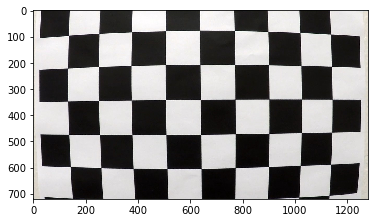

In [16]:
plt.imshow(image)
plt.show()

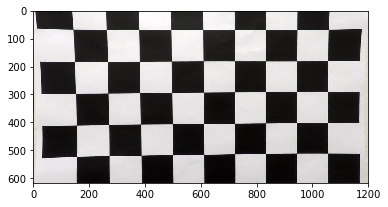

In [18]:
plt.imshow(utils.undistort(image))
plt.show()

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. 

I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [31]:
img = utils.load_image("./data/test_images/test5.jpg")

In [32]:
plt.imsave('./data/output_images/birdseye.png', utils.first2bird(utils.undistort(img)))

In [ ]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
rgb = img
yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [ ]:
plt.imshow(hsv[:,:,2],cmap='gray')

In [ ]:
def yellowandwhite(hsv_image):
    
    masks = []
    
    low_white,  high_white =  np.array([0, 0, 205]),  np.array([255, 40, 255])
    low_yellow, high_yellow = np.array([20, 40, 100]),np.array([70, 255, 255])
    
    white = cv2.inRange(hsv_image, low_white, high_white)
    masks.append(white)
    
    yellow = cv2.inRange(hsv_image, low_yellow, high_yellow)
    masks.append(yellow)
    
    return cv2.add(*masks)

In [ ]:
plt.imshow(yellowandwhite(hsv), cmap='gray')
plt.show()

### Binarify function.

In [43]:
binary = binarify(bird)

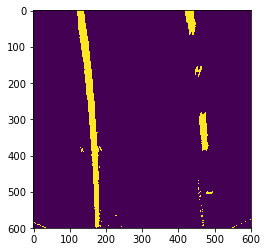

In [44]:
plt.imshow(binary)
plt.show()

### Bird's eye transform

In [ ]:
plt.imshow(binary_warped)
plt.show()

### Lane search, sliding window

In [ ]:
binary_warped.shape

In [ ]:
image_height, image_width  = binary_warped.shape
midpoint = np.int(image_width/2)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(5*image_height/7):,:], axis=0)
plt.plot(histogram)

leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [ ]:
leftx_base, rightx_base

In [ ]:
num_windows = 10
window_height = image_height/num_windows

#number of pixels to the left and right of the center spike. ie window_width/2
window_offset = 50

In [ ]:
def convert_box(coord1, coord2):
    
    if coord2[:]<coord1[:]:
        temp = coord1
        coord1 = coord2
        coord2 = temp
    
    height = coord2[0]-coord1[0]
    width = coord2[1]-coord1[1]
    return (coord1[0], coord1[1]), height, width

In [ ]:
leftx, rightx = leftx_base, rightx_base
leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
lane_lines = np.zeros_like(binary_warped)
boxs = []

for y_high in range(int(num_windows*window_height), 0, int(-window_height)):
    y_low = int(y_high-window_height)
    
    lhistogram = np.sum(binary_warped[y_low:y_high,leftleft:leftright], axis=0)
    rhistogram = np.sum(binary_warped[y_low:y_high,rightleft:rightright], axis=0)
    
    if np.max(lhistogram):
        leftx = np.argmax(lhistogram)+leftleft
    if np.max(rhistogram):
        rightx = np.argmax(rhistogram)+rightleft
    
    leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
    
    boxs += convert_box([leftleft,y_low],[leftright,y_high]), convert_box([rightleft,y_low],[rightright,y_high])
    
    lane_lines[y_low:y_high, leftleft: leftright] =  binary_warped[y_low:y_high, leftleft:leftright] 
    lane_lines[y_low:y_high, rightleft:rightright] = binary_warped[y_low:y_high, rightleft:rightright] 


In [ ]:

fig,ax = plt.subplots(1)
ax.imshow(lane_lines)

for box in boxs:
    rect = patches.Rectangle(box[0],box[1],box[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

histogram = np.sum(lane_lines, axis=0)
plt.plot(histogram)
plt.show()


### Fitting the lane lines to a curve

In [ ]:
y, x = np.nonzero(lane_lines)

In [ ]:
y, x = np.nonzero(lane_lines)
plt.scatter(x, 720-y)

In [ ]:
leftx, lefty = x[x<800], 720-y[x<800]
rightx, righty = x[x>800], 720-y[x>800]
rightx

In [ ]:
left_fit = np.polyfit(lefty, leftx, 2)
left_fit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
y, x = np.nonzero(lane_lines)
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

leftx, lefty = x[x<750], 720-y[x<750]
rightx, righty = x[x>750], y[x>750]

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as npimg 
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import glob
import matplotlib.patches as patches
from scipy import signal as sg
from utils import *
%matplotlib inline

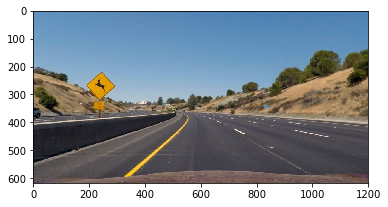

In [6]:
original_image = load_image('data/test_images/test2.jpg')
image = undistort(original_image)
plt.imshow(image)
plt.show()

In [7]:
bird = first2bird(image)

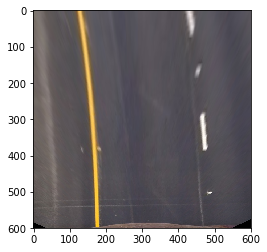

In [8]:
plt.imshow(bird)
plt.show()

In [9]:
binary = binarify(bird)

In [35]:
lanelines, left_fit, right_fit = blindlanefinder(binary)

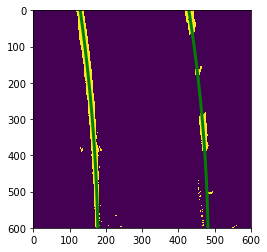

In [41]:
ploty = np.linspace(0, 599, num=600)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.imshow(lanelines)



plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

plt.savefig('./data/output_images/fitted_lines.png')

In [12]:
laned_image = drawlane(le, ri, image)

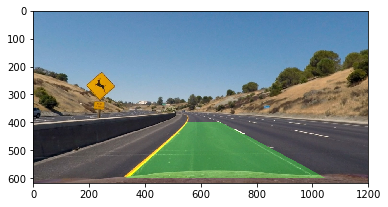

In [13]:
plt.imshow(laned_image)
plt.show()

## And so on and so forth...

The goals / steps of this project are the following:

* (done) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* (done) Apply a distortion correction to raw images.
* (improve) Use color transforms, gradients, etc., to create a thresholded binary image.
* (done) Apply a perspective transform to rectify binary image ("birds-eye view").
* (done) Detect lane pixels and fit to find the lane boundary.
* (needs fix) Determine the curvature of the lane and vehicle position with respect to center.
* (done) Warp the detected lane boundaries back onto the original image.
* (improve) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
